# Integration grids


These exercises are based on [the 2020 paper by Morgante](https://onlinelibrary.wiley.com/doi/10.1002/qua.26332). Some of the description is based on [the Q-Chem manual](https://manual.q-chem.com/5.4/qchem_manual.pdf) and [a 2019 working paper](http://doi.org/10.26434/chemrxiv.8864204.v5).

In order to do DFT calculations we use an integration grid when evaluating the exchange–correlation integrals as there is no analytical form of the integrals. There are many integration schemes around. Most of them calculate the integrals as weighted sum over a finite amount of grid points generally defined on the surface of a sphere. The “thickness” of these grids is usually represented by the corresponding number of radial and angular points. The choice of the grid can significantly affect the computed results.
The SG-0 and SG-1 (pruned 50,194 with < 40% of the points of the full grid) grids were optimized for an integration error in the energy to fall below a target threshold. Unfortunately, derivatives of the energy (eg. (hyper)polarizabilities) are often more sensitive to the quality of the integration grid. 
This is also true when imaginary vibrational frequencies or PES curves of non-bonded interactions are are calculated. A lack of rotational invariance in an integration grid can also yield uncertainities in isomerization reactions for example. If the grid is low quality,  low-frequency (but real) vibrational frequencies might manifest as imaginary and PES curves might contain artefacts.

More recent functionals developed since ~2005 often depend on the kinetic energy density or the laplacian of the density (e.g Meta-GGA functionals) and require finer grids than GGA functionals. 

The issue of choosing the most appropriate integration grid is often overlooked. Relying on the default settings of quantum chemistry programs is not a good idea, even if some developers implemented variable grid requirements that depend on the chosen functional (e.g in Q-Chem). In this experiment we will look at the dissociation curve of the argon dimer, between 3.0 and 6.0 Ångström using psi4 which uses the medium quality 75, 302 grid as default. 

We will test two functionals: `b3lyp` and  `m06-hf`. 



In [1]:
import psi4
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Lets create the distances we will be looking at
distances = np.linspace(3, 6, 31)

In [3]:
reference = [2.24,1.21, 0.57, 0.18, -0.06, -0.19, -0.26, -0.28, -0.28 , -0.27, -0.25, -0.23, -0.21, -0.18, -0.16, -0.14, -0.13, -0.11, -0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.05, -0.04, -0.04, -0.03, -0.03, -0.03, -0.02]

## BLYP functional

In [4]:
psi4.core.clean()
psi4.core.clean_options()
psi4.core.set_output_file('grid.log', False)
functional = "b3lyp" # b3lyp and m06-hf
energies = {}
distances = np.linspace(3, 6, 31)

grid_options = {
    'sg1':{'dft_grid_name':'sg1'},
    '75-302':{'dft_radial_points':75, 'dft_spherical_points': 302},
    '99-590':{'dft_radial_points':99, 'dft_spherical_points': 590}
}

for grid in grid_options.keys():
    psi4.core.clean_options()
    psi4.set_options(grid_options[grid])

    energies[grid] = []

    for R in distances:
        # Argon Dimer Z-Matrix
        ar_dimer = psi4.geometry(f"""
        0 1
        Ar 
        Ar 1 {R}
        """)
        energies[grid].append(psi4.energy(functional+"/def2-QZVP", molecule=ar_dimer))
    

In [5]:
# Calculate energy of single Argon atom
psi4.core.clean_options()
ar = psi4.geometry("""
Ar 0 0 0
""")

E_ar = psi4.energy(functional+"/def2-QZVP", molecule = ar)

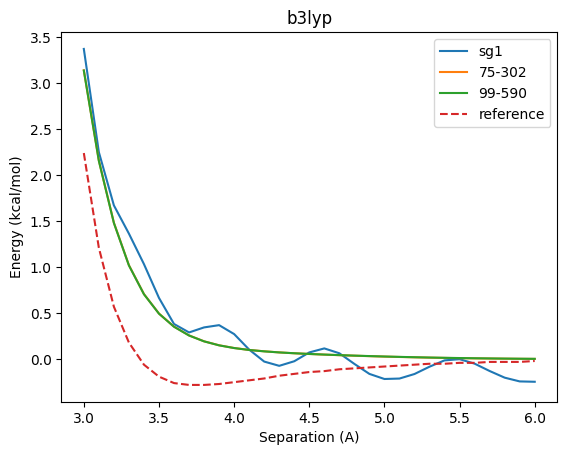

In [6]:
fig, ax = plt.subplots(1)
ax.set_title(functional)
# we plot the curves for each grid we used 
for grid in grid_options.keys():
    # the interaction energy is the E_dimer - 2*E_single
    # you can use psi4.constants.hartree2kcalmol for the unit conversion    
    # you can access the energy for gridpoint X by using
    #   np.array(energies[X]), where X is the gridpoint you are interested in 
    Interaction_Energy = (np.array(energies[grid]) - 2.0 * E_ar) * psi4.constants.hartree2kcalmol 
    ax.plot(distances, Interaction_Energy, label=grid)
ax.plot(distances, reference, label='reference', linestyle="--")
ax.set_xlabel('Separation (A)')
ax.set_ylabel('Energy (kcal/mol)')
ax.legend()
fig.savefig(functional+'-integrationgrid.jpg')
plt.show()

In [13]:
psi4.core.clean()
psi4.core.clean_options()
psi4.core.set_output_file('grid.log', False)
functional = "b3lyp" # b3lyp and m06-hf
E_atom = {}          # dictionnaire
energies = {}
distances = np.linspace(3, 6, 31)

grid_options = {
    'sg1':{'dft_grid_name':'sg1'},
    '75-302':{'dft_radial_points':75, 'dft_spherical_points': 302},
    '99-590':{'dft_radial_points':99, 'dft_spherical_points': 590}
}

for grid in grid_options.keys():
    psi4.core.clean_options()
    psi4.set_options(grid_options[grid])

    ar = psi4.geometry("Ar 0 0 0")
    E_atom[grid] = psi4.energy(functional+"/def2-QZVP", molecule=ar)

    energies[grid] = []

    for R in distances:
        # Argon Dimer Z-Matrix
        ar_dimer = psi4.geometry(f"""
        0 1
        Ar 
        Ar 1 {R}
        """)
        energies[grid].append(psi4.energy(functional+"/def2-QZVP", molecule=ar_dimer))
    

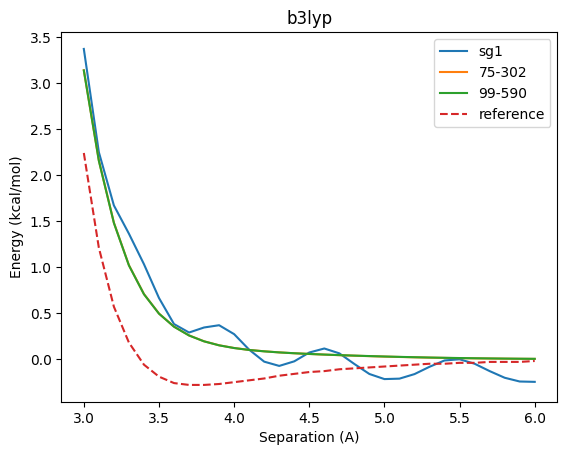

In [14]:
fig, ax = plt.subplots(1)
ax.set_title(functional)
# we plot the curves for each grid we used 
for grid in grid_options.keys():
    # the interaction energy is the E_dimer - 2*E_single
    # you can use psi4.constants.hartree2kcalmol for the unit conversion    
    # you can access the energy for gridpoint X by using
    #   np.array(energies[X]), where X is the gridpoint you are interested in 
    Interaction_Energy = (np.array(energies[grid]) - 2.0 * E_atom[grid]) * psi4.constants.hartree2kcalmol
    ax.plot(distances, Interaction_Energy, label=grid)
ax.plot(distances, reference, label='reference', linestyle="--")
ax.set_xlabel('Separation (A)')
ax.set_ylabel('Energy (kcal/mol)')
ax.legend()
fig.savefig(functional+'-integrationgrid.jpg')
plt.show()

## M06-HF functional

In [7]:
psi4.core.clean()
psi4.core.clean_options()
psi4.core.set_output_file('grid.log', False)
functional = "m06-hf" # b3lyp and m06-hf
energies = {}
distances = np.linspace(3, 6, 31)

grid_options = {
    'sg1':{'dft_grid_name':'sg1'},
    '75-302':{'dft_radial_points':75, 'dft_spherical_points': 302},
    '99-590':{'dft_radial_points':99, 'dft_spherical_points': 590}
}

for grid in grid_options.keys():
    psi4.core.clean_options()
    psi4.set_options(grid_options[grid])

    energies[grid] = []

    for R in distances:
        # Argon Dimer Z-Matrix
        ar_dimer = psi4.geometry(f"""
        0 1
        Ar 
        Ar 1 {R}
        """)
        energies[grid].append(psi4.energy(functional+"/def2-QZVP", molecule=ar_dimer))
    

In [8]:
# Calculate energy of single Argon atom
psi4.core.clean_options()
ar = psi4.geometry("""
Ar 0 0 0
""")

E_ar = psi4.energy(functional+"/def2-QZVP", molecule = ar)

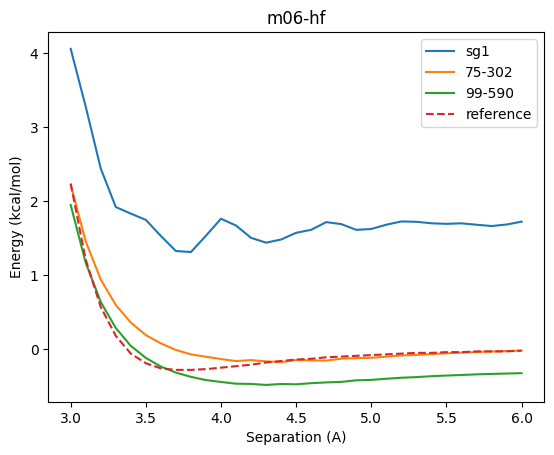

In [9]:
fig, ax = plt.subplots(1)
ax.set_title(functional)
# we plot the curves for each grid we used 
for grid in grid_options.keys():
    # the interaction energy is the E_dimer - 2*E_single
    # you can use psi4.constants.hartree2kcalmol for the unit conversion    
    # you can access the energy for gridpoint X by using
    #   np.array(energies[X]), where X is the gridpoint you are interested in 
    Interaction_Energy = (np.array(energies[grid]) - 2.0 * E_ar) * psi4.constants.hartree2kcalmol
    ax.plot(distances, Interaction_Energy, label=grid)
ax.plot(distances, reference, label='reference', linestyle="--")
ax.set_xlabel('Separation (A)')
ax.set_ylabel('Energy (kcal/mol)')
ax.legend()
fig.savefig(functional+'-integrationgrid.jpg')
plt.show()

## Comparison

Compare the plots you obtained with the two functionals using different grids, and answer the following questions:

```{admonition} Exercise 9
:class: exercise
Which grid size should you use for this kind of problem? Are the fluctuations observed with the SG1 grid physical? Evaluate plots you create above.
```



```{admonition} Exercise 10
:class: exercise
Compare the two functionals regarding convergence with respect to the integration grid. Which functional shows concerning behavior in this regard? Evaluate plots you create below.
```


In [11]:
psi4.core.clean()
psi4.core.clean_options()
psi4.core.set_output_file('grid.log', False)
functional = "m06-hf" # b3lyp and m06-hf
E_atom = {}          # dictionnaire
energies = {}
distances = np.linspace(3, 6, 31)

grid_options = {
    'sg1':{'dft_grid_name':'sg1'},
    '75-302':{'dft_radial_points':75, 'dft_spherical_points': 302},
    '99-590':{'dft_radial_points':99, 'dft_spherical_points': 590}
}

for grid in grid_options.keys():
    psi4.core.clean_options()
    psi4.set_options(grid_options[grid])

    ar = psi4.geometry("Ar 0 0 0")
    E_atom[grid] = psi4.energy(functional+"/def2-QZVP", molecule=ar)

    energies[grid] = []

    for R in distances:
        # Argon Dimer Z-Matrix
        ar_dimer = psi4.geometry(f"""
        0 1
        Ar 
        Ar 1 {R}
        """)
        energies[grid].append(psi4.energy(functional+"/def2-QZVP", molecule=ar_dimer))
    

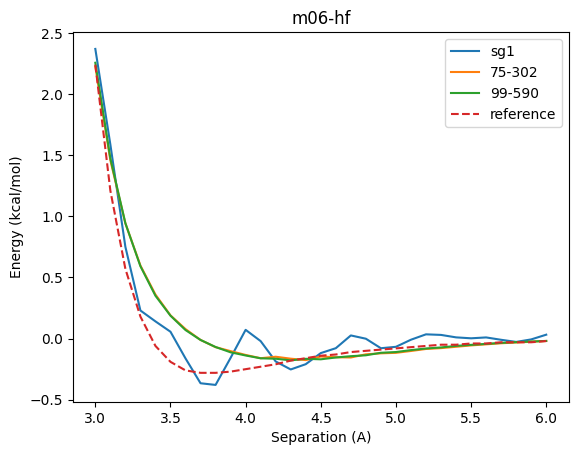

In [12]:
fig, ax = plt.subplots(1)
ax.set_title(functional)
# we plot the curves for each grid we used 
for grid in grid_options.keys():
    # the interaction energy is the E_dimer - 2*E_single
    # you can use psi4.constants.hartree2kcalmol for the unit conversion    
    # you can access the energy for gridpoint X by using
    #   np.array(energies[X]), where X is the gridpoint you are interested in 
    Interaction_Energy = (np.array(energies[grid]) - 2.0 * E_atom[grid]) * psi4.constants.hartree2kcalmol
    ax.plot(distances, Interaction_Energy, label=grid)
ax.plot(distances, reference, label='reference', linestyle="--")
ax.set_xlabel('Separation (A)')
ax.set_ylabel('Energy (kcal/mol)')
ax.legend()
fig.savefig(functional+'-integrationgrid.jpg')
plt.show()